In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers einops scikit-learn pandas matplotlib tqdm
!git clone https://github.com/MAGICS-LAB/DNABERT_2.git

Cloning into 'DNABERT_2'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 123 (delta 22), reused 15 (delta 15), pack-reused 92 (from 2)
Receiving objects: 100% (123/123), 882.58 KiB | 2.80 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [3]:
patch_code = """
import torch
from torch import nn
from transformers import BertModel, BertPreTrainedModel

class DNABert2Model(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config, add_pooling_layer=True)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        return self.bert(input_ids=input_ids,
                         attention_mask=attention_mask,
                         token_type_ids=token_type_ids)
"""
with open("DNABERT_2/dnabert2_model.py", "w") as f:
    f.write(patch_code)

In [4]:
import sys
sys.path.append("/content/DNABERT_2")

from dnabert2_model import DNABert2Model
from transformers import AutoTokenizer, AutoConfig
import torch

model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
model = DNABert2Model.from_pretrained(model_name, config=config, trust_remote_code=True)

device = torch.device("cuda")
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/168k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNABERT-2-117M:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/468M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/468M [00:00<?, ?B/s]

Some weights of DNABert2Model were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.embeddings.position_embeddings.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.val

DNABert2Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [5]:
import pandas as pd
import random

df = pd.read_csv('/content/drive/MyDrive/genomics_project/data/ctcf_benchmark_dataset.csv')
df = df.dropna()
# Greater than 30 to remove trivial cases as anything less can be too short for meaningful k-mer context
df = df[df['sequence'].str.len() > 30]
df = df[~df['sequence'].str.contains('^N+$')]
real_sequences = df['sequence'].sample(n=10000, random_state=42).tolist()

def shuffle_sequence(seq):
    shuffled = list(seq)
    random.shuffle(shuffled)
    return ''.join(shuffled)

shuffled_sequences = [shuffle_sequence(seq) for seq in real_sequences]

all_sequences = real_sequences + shuffled_sequences
labels = [1] * len(real_sequences) + [0] * len(shuffled_sequences)

print("Total sequences:", len(all_sequences))

Total sequences: 20000


In [6]:
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

accuracies, f1_scores, roc_aucs = [], [], []

for seed in [0, 1, 2, 3, 4]:
    print(f"\nShuffled Benchmark Run {seed+1}")

    combined = list(zip(all_sequences, labels))
    random.Random(seed).shuffle(combined)
    sequences, lbls = zip(*combined)

    embeddings = []
    for seq in tqdm(sequences, desc=f"Embedding Run {seed+1}"):
        inputs = tokenizer(seq, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        pooled = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings.append(pooled)

    embeddings = np.array(embeddings)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, lbls, test_size=0.2, random_state=seed)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    accuracies.append(acc)
    f1_scores.append(f1)
    roc_aucs.append(auc)

    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {auc:.4f}")


Shuffled Benchmark Run 1


Embedding Run 1: 100%|██████████| 20000/20000 [04:46<00:00, 69.78it/s]


Accuracy: 0.9265, F1: 0.9266, ROC AUC: 0.9779

Shuffled Benchmark Run 2


Embedding Run 2: 100%|██████████| 20000/20000 [04:45<00:00, 69.95it/s]


Accuracy: 0.9270, F1: 0.9275, ROC AUC: 0.9775

Shuffled Benchmark Run 3


Embedding Run 3: 100%|██████████| 20000/20000 [04:46<00:00, 69.81it/s]


Accuracy: 0.9260, F1: 0.9241, ROC AUC: 0.9766

Shuffled Benchmark Run 4


Embedding Run 4: 100%|██████████| 20000/20000 [04:46<00:00, 69.83it/s]


Accuracy: 0.9235, F1: 0.9239, ROC AUC: 0.9761

Shuffled Benchmark Run 5


Embedding Run 5: 100%|██████████| 20000/20000 [04:47<00:00, 69.50it/s]


Accuracy: 0.9277, F1: 0.9280, ROC AUC: 0.9779


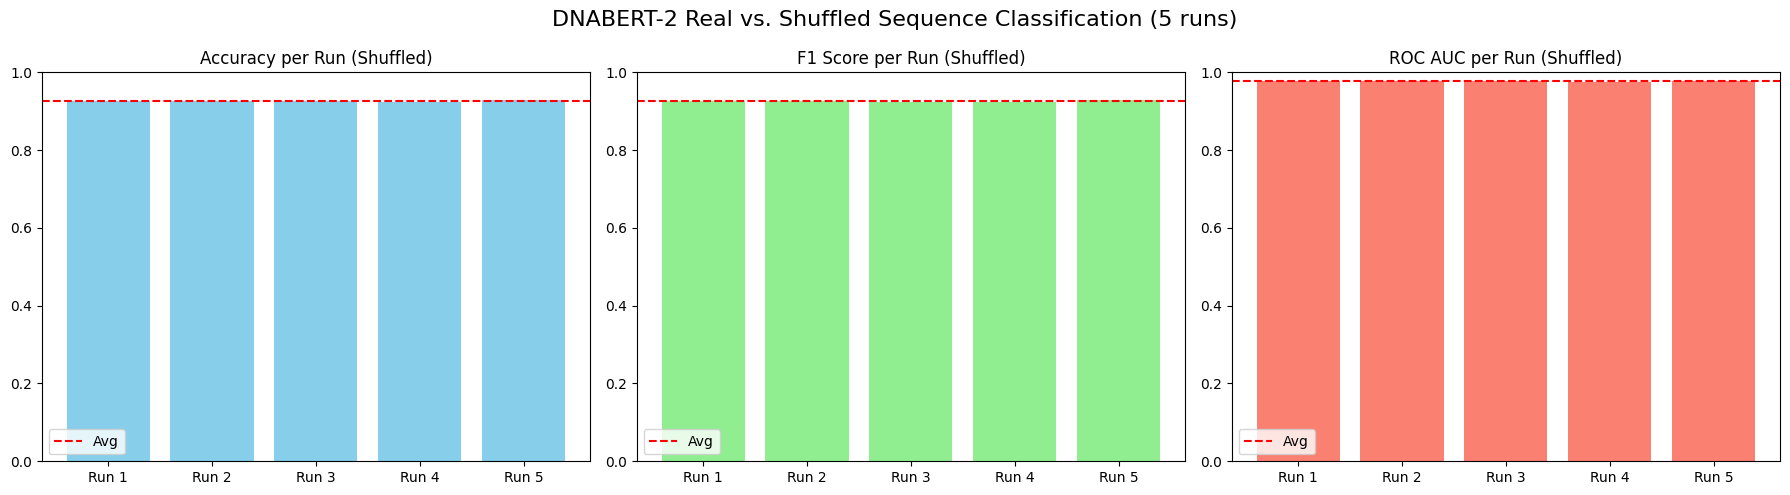

In [7]:
import matplotlib.pyplot as plt

runs = [f"Run {i+1}" for i in range(5)]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(runs, accuracies, color='skyblue')
axs[0].axhline(y=np.mean(accuracies), color='red', linestyle='--', label='Avg')
axs[0].set_title('Accuracy per Run (Shuffled)')
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].bar(runs, f1_scores, color='lightgreen')
axs[1].axhline(y=np.mean(f1_scores), color='red', linestyle='--', label='Avg')
axs[1].set_title('F1 Score per Run (Shuffled)')
axs[1].set_ylim(0, 1)
axs[1].legend()

axs[2].bar(runs, roc_aucs, color='salmon')
axs[2].axhline(y=np.mean(roc_aucs), color='red', linestyle='--', label='Avg')
axs[2].set_title('ROC AUC per Run (Shuffled)')
axs[2].set_ylim(0, 1)
axs[2].legend()

fig.suptitle('DNABERT-2 Real vs. Shuffled Sequence Classification (5 runs)', fontsize=16)
plt.tight_layout()
plt.show()